# 영화 데이터셋을 이용한 추천 모델 학습
----------
    
    
## 데이터 소개
    - MovieLens Dataset을 사용
    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    
- 데이터 출처: https://grouplens.org/datasets/movielens/
---

## Step 1. 데이터 전처리

### 데이터 불러오기

In [1]:
import pandas as pd

rating_url = './data/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')
rating_df.head()
# time: 유닉스 타임, 클수록 현재에 가까움

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
movie_url = './data/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### EDA - 사용자 수 및 영화개수

In [3]:
len(rating_df['user_id'].unique())

6040

In [4]:
len(rating_df['movie_id'].unique())

3706

### EDA - 영화평가 점수 분포

In [5]:
import matplotlib.pyplot as plt

<Axes: >

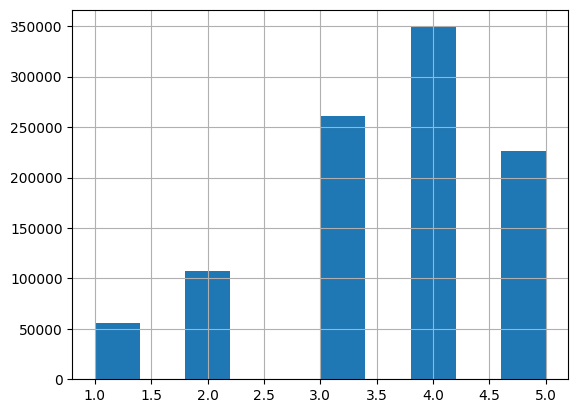

In [6]:
rating_df['rating'].hist()

### Step 2. CF-based 모델링 (KNN)

### Rating Matrix와 Collaborative Filtering (CF)
----------

#### Rating Matrix

![rating matrix](https://www.researchgate.net/profile/Giuseppe_Manco3/publication/220907096/figure/fig1/AS:305570830667776@1449865171054/An-example-of-rating-matrix.png)

    1. User를 Row, Item을 Column으로 하며 Value를 Rating으로 하는 행렬
    2. Rating의 종류
      - Explicit Feedback : 영화 점수, 리뷰 점수, 좋아요 표시...
      - Implicit Feedback : 조회, 시청, 구매, 찜 표시... -> 실제 추천시스템에 가장 많이 활용됨
    3. 위 행렬에서 빈 곳의 점수를 예측하는 방법
    4. Rating Matrix를 추천 모델로 활용하는 방법
      - Collaborative Filtering (CF)
      - Matrix Factorization (MF)

-----

#### Collaborative Filtering (CF)

![CF](./assets/Figure1.png)

> User3이 서울의 봄을 평가한 정보는 없지만, 다른 영화들을 어떻게 평가했는지는 User1과 비슷하다고 볼 수 있다. 따라서, User1이 서울의 봄을 평가한 것을 토대로 User3도 서울의 봄에 5점에 가까운 점수를 줄 것이라 예상하고, 서울의 봄을 User3에게 추천하는 방식을 CF라 한다. 
    
    1. User-based
    2. Item-based : 새로 개봉한 영화의 장르 등 영화 정보만을 바탕으로 추천하는 방식

-----

### Train/Test 데이터 분리

In [7]:
!pip install surprise

In [8]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

### KNN 모델 학습

-----

#### KNN (K-Nearest Neighbor) 알고리즘
> 새로운 입력으로 들어온 데이터를 특정값으로 분류하는데 현재 데이터와 가장 가까운 K개의 데이터를 찾아 가장 많은 분류 값으로 현재의 데이터를 분류하는 알고리즘

![knn](https://ineed-coffee.github.io/assets/knn.png)
> 새로운 혹은 특정한 데이터 별이 들어왔을 때 별과 가장 근접한 K개의 데이터를 이용해서 별이 파란색인지 노란색인지 찾아내는 알골리즈ㅡㅁ

#### Surprise의 KNN

> A basic collaborative filtering algorithm. The prediction 𝑟̂ 𝑢𝑖 is set as

![suprise knn](https://drive.google.com/uc?id=1P9sMYJf2232m1Hi0ONfdHp3YT7L7AFHf)

###### (https://surprise.readthedocs.io/en/stable/knn_inspired.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. User-based CF
    2. 유저 A와 가장 영화를 유사하게 평가한 유저 k명을 선정
    3. k명의 유저가 영화 a를 평가한 점수를 활용하여 위의 식대로 점수를 계산함
    4. 이와 같은 방식으로 Rating Matrix를 완성
-----
    [Similarity]
    1. 가장 일반적인 Similarity 계산 방식은 cosine similarity
    2. 다른 방식은 euclidean distance, jaccard index, pearson correlation 등이 있음

![cosine](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/1_cosine-similarity.png)
-----

In [9]:
# KNN의 이해를 돕기 위한 참고 코드

aa = (0.9 * 5) + (0.9 * 4.3) + (1.0 * 5)
bb = (0.9) + (0.9) + (1.0)
aa/bb

4.775

In [10]:
# 모델학습을 위한 라이브러리
from surprise import KNNBasic
# 모델이 얼마나 잘 학습되었는지를 평가하는 라이브러리
from surprise import accuracy

algo = KNNBasic(k=40, min_k=1, sim_options={"user_based": True, "name": "cosine"})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 모델 평가 - RMSE 이용

In [11]:
accuracy.rmse(predictions)

RMSE: 0.9748


0.9747836121151744

### 테스트 데이터셋에서 일부 결과 확인

In [12]:
predictions = algo.test(testset[:20])
predictions


[Prediction(uid=1556, iid=3097, r_ui=5.0, est=4.153330435179539, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5205, iid=110, r_ui=5.0, est=4.1748409289313315, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5341, iid=2871, r_ui=4.0, est=4.050412902704427, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5647, iid=2077, r_ui=2.0, est=3.4984822290436646, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1285, iid=1172, r_ui=4.0, est=4.625138395475403, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=4974, iid=356, r_ui=3.0, est=4.0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5181, iid=3155, r_ui=4.0, est=3.7747508260892615, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2453, iid=1704, r_ui=5.0, est=4.298657471684807, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2808, iid=2010, r_ui=4.0, est=4.300793482731878, details={'ac

In [13]:
for _, iid, r_ui, est, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", est)

Item id 3097 | real rating : 5.0 | predicted rating : 4.153330435179539
Item id 110 | real rating : 5.0 | predicted rating : 4.1748409289313315
Item id 2871 | real rating : 4.0 | predicted rating : 4.050412902704427
Item id 2077 | real rating : 2.0 | predicted rating : 3.4984822290436646
Item id 1172 | real rating : 4.0 | predicted rating : 4.625138395475403
Item id 356 | real rating : 3.0 | predicted rating : 4.0
Item id 3155 | real rating : 4.0 | predicted rating : 3.7747508260892615
Item id 1704 | real rating : 5.0 | predicted rating : 4.298657471684807
Item id 2010 | real rating : 4.0 | predicted rating : 4.300793482731878
Item id 1500 | real rating : 4.0 | predicted rating : 3.6505951583569156
Item id 1544 | real rating : 4.0 | predicted rating : 3.5983460052138856
Item id 454 | real rating : 5.0 | predicted rating : 3.7740176370177005
Item id 11 | real rating : 4.0 | predicted rating : 3.825
Item id 914 | real rating : 3.0 | predicted rating : 4.376403588886951
Item id 356 | real